# 1 - Introduction

This notebook explores whether non-linear models can outperform the baseline linear logistic regression model. Decision trees are an efficient method for of accounting for non-linearities. They are a particularly good choice for this project since they can naturally produce probability estimates. Probability estimates are needed for computing the area under the curve, my preferred performance metric. I will start by developing single tree models. I will then investigate whether Random Forests or Boosted Trees, models that grow multiple trees, outperform the single tree model.

## 1.1 - Load Packages and Global Variables

In [1]:
%matplotlib inline

In [2]:
import os
import time
from datetime import datetime
import luigi
from sklearn.externals import joblib
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import log_loss, roc_auc_score
import numpy as np
import pandas as pd
import graphviz
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import distributions
from IPython.display import SVG
import xgboost as xgb
from itertools import product
from IPython.display import HTML

In [3]:
PROJECT_DIR = os.path.join(os.getcwd(), os.pardir)
os.chdir(PROJECT_DIR)

In [4]:
from src.features.dtm import CreateDTM
from src.visualization import evaluation

In [5]:
import imp
evaluation = imp.reload(evaluation)

## 1.2 - Load the Data

The following Luigi task ensures that the document-term matrices for both train and test are available.

In [6]:
luigi.build([CreateDTM()], local_scheduler = True)

DEBUG: Checking if CreateDTM() is complete
INFO: Informed scheduler that task   CreateDTM__99914b932b   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=436753127, workers=1, host=DESKTOP-6UJS098, username=wertu, pid=9256) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 present dependencies were encountered:
    - 1 CreateDTM()

Did not run any tasks
This progress looks :) because there were no failed tasks or missing external dependencies

===== Luigi Execution Summary =====



True

Now that we have ensured that the data exists, load it:

In [7]:
features = joblib.load("data/processed/dtm_features.pkl")
train = joblib.load("data/interim/train.pkl")
test = joblib.load("data/interim/test.pkl")
lin_mdl = joblib.load("models/best_linear.pkl")

# 2 - Basic Trees

We will start with the "basic" decision tree model, which consists of a single decision tree with many splits.

We will first assess the results of training a decision treee model using sklearn's default Models composed of a single fully grown decision trees are prone to overfitting. Therefore we will engage in hyperparameter tuning to produce optimal results

The sklearn implementation of decision trees uses the CART algorithm. The CART algorithm creates splits based on numeric criteria.

# 2.1 - Untuned Model

Before starting to tune the hyperparameters of the decison tree, let us train and assess a decision tree model using the default sklearn settings.

In [8]:
%%time
dt_base = DecisionTreeClassifier(max_depth = None, random_state = 99)
dt_base.fit(features["train"], train.funny)

Wall time: 11min 57s


### 2.1.1 - Perfomance

Let us evaluate the performance on the test set.

In [9]:
dt_base.score(features["test"], test.funny)

0.62311057367428957

The above accuracy is quite low, lower than the linear model. This is not good. Let us calculate the AUC and compare it to the benchmark lienar model

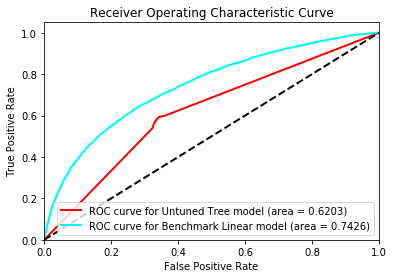

In [10]:
dt_base_probs = dt_base.predict_proba(features["test"]) [:, 1]
lin_probs = lin_mdl.predict_proba(features["test"]) [:, 1]
evaluation.roc_plot(test.funny,
                    [dt_base_probs, lin_probs],
                    ["Untuned Tree", "Benchmark Linear"],
                    'reports/figures/ROC_dt_base.svg')

We can see that the initial, unoptimized, decision tree model significantly underperforms the best linear model. This is not surprising, since decision trees have a tendency to overfit. This tendency to overfit can also be observed from the relatively long time that it takes to fit the model. The number of terminal nodes (leaves) is an also an indication of how hard the model is fitting to the data. 

In [11]:
#difference between train and test scores indicate overfitting
dt_base.score(features["train"], train.funny)

0.98509745340731258

In [12]:
unique_leaves = np.unique(dt_base.apply(features["train"]))
num_leaves = len(unique_leaves)
print("There are {} terminal nodes".format(num_leaves))
obs_per_leaf = features["train"].shape[0] / len(unique_leaves)
print("There are an average of {:0.2f} observations in a terminal node.".format(obs_per_leaf))

There are 41026 terminal nodes
There are an average of 4.80 observations in a terminal node.


### 2.1.2 - Visualization

Let's visualize the very upper portion of the tree.

In [13]:
tree_dot = export_graphviz(dt_base,
                           out_file=None,
                           feature_names=features["vectorizer"].get_feature_names(),
                           label='all',
                           filled=True,
                           class_names=["Unfunny", "Funny"],
                           proportion=True,
                           max_depth=3)

In [14]:
tree_graph = graphviz.Source(tree_dot,
                             format='svg',
                             engine="dot",
                             filename="reports/figures/tree_visual")
display(HTML(open(tree_graph.render()).read()))

From the above visualization, one can see that jokes with dialogue are funny.

### 2.1.3 Feature Importance

Finally, let us examine the most important features

In [15]:
top_base_features = np.argsort(dt_base.feature_importances_)[-50:]
np.array(features["vectorizer"].get_feature_names())[top_base_features]

array(['gets', 'called', 'went', 'jokes', 've', 'favorite', 'sex', 'night',
       'really', 'think', 'good', 'friend', 'girl', 'dad', 'little',
       'today', 'common', 'old', 'bar', 'going', 'told', 'girlfriend',
       'tell', 'trump', 'replies', 'new', 'asked', 'guy', 'day', 'll',
       'got', 'make', 'difference', 'black', 'know', 'people', 'time',
       'man', 'replied', 'say', 'joke', 'does', 'like', 'don', 'just',
       'asks', 'wife', 'did', 'said', 'says'],
      dtype='<U59')

One can see a fair of amount of synomoms or similar words above. This suggests more processing of features could be done. However this is time consuming. More advanced and efficient techniques for dealing with semantically similary words will be explored when training neural networks models.

## 2.2 - Tuning

As the preceding section shows, the basic, untuned, decision tree model underperforms the linear model by signifcant margin. In this section, we will try and improve the performance of the basic decision tree by evaluating the perfomance of the basic decision tree under various combinations of hyperparameters. The hyperparameters that we will try help reduce overfitting by stopping growth once the tree has become too complex. As an added bonus, a less complex decision tree will faster to train.

### 2.1.1 - Random Search 

Rather than engaging in an exhaustive grid search for the optimal set of hyperparameters, we will instead try a randomized search. For each iteration, a randomized search samples the specified hyperparameters from a distribution. This can be much more efficient than an exhaustive grid search.

See http://www.jmlr.org/papers/v13/bergstra12a.html

In [16]:
min_impurity_decrease = distributions.uniform(loc = 1e-6, scale = (1e-3 - 1e-6))
min_samples_split = distributions.poisson(6, 1)

to_search = {'min_impurity_decrease':min_impurity_decrease,
            'min_samples_split':min_samples_split}

In [31]:
%%time
dt_best = RandomizedSearchCV(estimator = DecisionTreeClassifier(),
                  param_distributions=to_search,
                  n_jobs=10,
                  n_iter=50,        
                  cv=8,
                  verbose=1,
                  random_state=11222017)
dt_best.fit(features["train"], train.funny)

Fitting 8 folds for each of 50 candidates, totalling 400 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   42.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  4.4min
[Parallel(n_jobs=10)]: Done 400 out of 400 | elapsed: 14.8min finished


Wall time: 17min 43s


### 2.1.2 Results

Now that we have the results, let us analyze them. 

First, let's see if we can visually detect any pattern in the best performing hyperparameter sets.

In [32]:
results = pd.DataFrame(dt_best.cv_results_).sort_values("rank_test_score", ascending = True)
results = results.loc[:, ["mean_test_score",
                         "mean_train_score",
                         "param_min_impurity_decrease",
                         "param_min_samples_split",
                         "rank_test_score"]]
results = results.astype(dtype={'param_min_impurity_decrease':np.float,
                                'param_min_samples_split':int})
results.head(20)

,mean_test_score,mean_train_score,param_min_impurity_decrease,param_min_samples_split,rank_test_score
45,0.627904,0.735799,0.000020,8,1
20,0.624611,0.643116,0.000045,8,2
35,0.605598,0.608303,0.000145,5,3
27,0.605598,0.608303,0.000144,7,3
34,0.604409,0.606428,0.000172,11,5
46,0.603103,0.604898,0.000200,9,6
1,0.602560,0.604034,0.000213,11,7
31,0.602524,0.603998,0.000218,9,8
2,0.602204,0.603607,0.000229,10,9
14,0.601757,0.602735,0.000252,6,10


It is hard to detect a pattern from the above tables, but it does seem the hyperparameters that allow for more complexity produce more accurate models. Let's verify this hunch.

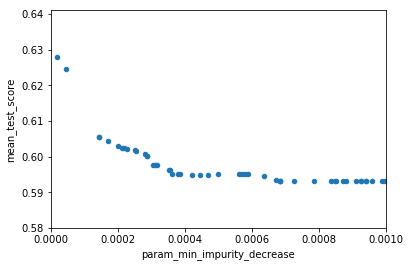

In [33]:
results.plot(x="param_min_impurity_decrease",
             y = "mean_test_score", 
             kind="scatter",
             xlim=(1e-6,1e-3))

In [ ]:
results.plot(x="param_min_impurity_decrease",
             y = "mean_test_score", 
             kind="scatter",
             xlim=(1e-6,1e-3))

The above plot is more enlighting; it suggests a "sweet" point for the __min_impurity_decrease__ around 0.0002. Finally let us analyze the variance vs bias tradeoff by plotting the train accuracy against test accuracy.

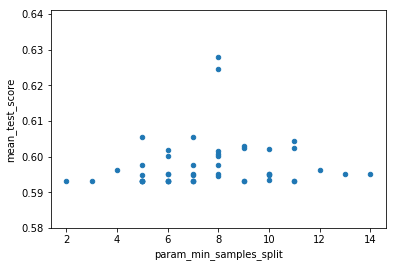

In [39]:
results.plot(x="param_min_samples_split",
             y = "mean_test_score", 
             kind="scatter")

Again, the above plot indicates there is a "sweet" point for the test results in terms of fitting to the train data set. The test accuracy increases with the train accuracy up to a certain point and then starts decreasing.

Now that we have analyzed the relationship between the cross validation results and the hyperparameter settings, let us analyze the performance of the best set of hyperparameters. 

In [35]:
dt_best_score = dt_best.score(features["test"], test.funny)
print(dt_best_score)

0.633744709606


The above score on test is a fairly substansial improvement on the untuned decision tree. Let us verify that the spread between the train and test error is reduced because of increased regularization.

In [36]:
dt_best.score(features["train"], train.funny)

0.71510375383614821

As one can see, performance on the train set is better than on the test. However the difference is not huge. Due to rgualrization.

The sklearn RandomizedSearchCV automatically refits to the best results. Therefore we can be confident that a well tuned basic decsion tree underperforms an optimized linear model to a noticeable degree. Let us verify these results using our preferred metric, Area Under the Curve:   

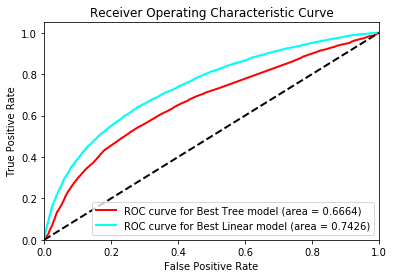

In [37]:
#lets look at area under the curve
dt_best_preds = dt_best.predict_proba(features["test"]) [:, 1]
lin_probs = lin_mdl.predict_proba(features["test"]) [:, 1]
evaluation.roc_plot(test.funny,
                    [dt_best_preds, lin_probs],
                    ["Best Tree", "Best Linear"],
                    'reports/figures/ROC_dt_best.svg')

Here with the ROC curve, we again can see an improvement. Closer to linear benchmarkc, but sitll undr performs by a fair amount.

In [38]:
#save the best model
joblib.dump(dt_best,"models/best_tree.pkl")

['models/best_tree.pkl']

The Area Under the Curve metric is consistent with the accuracy. Underperfomance compared to the linear model.

# 3 - Bagged Trees (Random Forest)

After having tried basic decision trees, we will now try the random forest algorithm. An advantage of random forests is that they do not require many hyperparameters.

"The random forests algorithm, which is also an ensemble-of-trees method, is generally regarded to be among the very best
commonly used classifiers (Manuel Fern´andez-Delgado and Amorim, 2014)" from "AdaBoost and Random Forests: the Power of Interpolation"

## 3.1 Hyperparameter search

Despite random forests not needing too many hyperparmeters, they still require some tuning of hyperparameters in order to obtain optimal results.

Rather than using k-fold cross validation to determine the best parameters, I will use the out of bag (oob) error to evaluate ther performance of different hyperparameters. The out of bag errors metric is good because the random fforest alorithm naturally produces a hold out set, similar to k-fold cross validation. 

The morst import parameters are the numer of trees (n_estimators) and the number of features that are considered at each split (max_features). For max_features, I will try the default (and widely used) square-root of the number of features, as well as the built in log2 of the number of fetures. For the number of trees, I will start with the default number of 10 and increase up to 750.

>_"The study of error estimates for bagged classifiers in Breiman [1996b], gives empirical evidence to show that the out-   of-bag estimate is as accurate as using a test set of the same size as the training set. Therefore, using the out-of-bag error estimate removes the need for a set aside test set."_

In [25]:
%%time
#want to fit rf model with warm start again and again
#each time adding 50 trees
#do for 5 hours
#then switch to sqrt
results = []
start_time = time.time()
elapsed_time = time.time() - start_time
rf_log2 =  RandomForestClassifier(max_features="log2",
                                 n_estimators = 50,
                                 n_jobs=10,
                                 oob_score = True,
                                 warm_start = True,
                                 random_state=11202017)
rf_sqrt =  RandomForestClassifier(max_features="sqrt",
                                 n_estimators = 50,
                                 n_jobs=10,
                                 oob_score = True,
                                 warm_start = True,
                                 random_state=11202017)
print("Starting log2")
log2_n_estimators = 50
while ((time.time() - start_time)/(60*60) < 5):
    print("Fitting log2 with {} estimators".format(log2_n_estimators))
    rf_log2.set_params(n_estimators=log2_n_estimators)
    rf_log2.fit(features["train"], train.funny)
    n_estimators_check = len(rf_log2.estimators_)
    print("Actual number of estimators: {}".format(n_estimators_check))
    score = rf_log2.oob_score_
    print("Score of {}".format(score))
    results.append((log2_n_estimators, "log2", score))
    print("elapsed time: {} minutes".format((time.time() - start_time)/60))
    log2_n_estimators += 50

print("Done log2 after {} minutes".format((time.time() - start_time)/60))
print("Starting sqrt")
sqrt_n_estimators = 50
while sqrt_n_estimators < log2_n_estimators:
    print("Fitting sqrt with {} estimators".format(sqrt_n_estimators))
    rf_sqrt.set_params(n_estimators=sqrt_n_estimators)
    rf_sqrt.fit(features["train"], train.funny)
    n_estimators_check = len(rf_sqrt.estimators_)
    print("Actual number of estimators: {}".format(n_estimators_check))
    score = rf_sqrt.oob_score_
    print("Score of {}".format(score))
    results.append((sqrt_n_estimators, "sqrt", score))
    print("elapsed time: {} minutes\n".format((time.time() - start_time)/60))
    sqrt_n_estimators += 50

Starting log2
Fitting log2 with 50 estimators
Actual number of estimators: 50
Score of 0.670197955409223
elapsed time: 28.341313179334005 minutes
Fitting log2 with 100 estimators
Actual number of estimators: 100
Score of 0.6825193585756966
elapsed time: 57.18701001405716 minutes
Fitting log2 with 150 estimators
Actual number of estimators: 150
Score of 0.6887029246184175
elapsed time: 86.87337716023127 minutes
Fitting log2 with 200 estimators
Actual number of estimators: 200
Score of 0.691101152368758
elapsed time: 117.60085274378459 minutes
Fitting log2 with 250 estimators
Actual number of estimators: 250
Score of 0.6934688941731195
elapsed time: 149.60509004592896 minutes
Fitting log2 with 300 estimators
Actual number of estimators: 300
Score of 0.6942157998496027
elapsed time: 182.62652870019278 minutes
Fitting log2 with 350 estimators
Actual number of estimators: 350
Score of 0.6956435583196147
elapsed time: 216.54820310672125 minutes
Fitting log2 with 400 estimators
Actual number 

Let us put the results into a pandas dataframe.

In [30]:
results = pd.DataFrame(results, columns = ["n_estimators", "max_features", "oob_score"])
results.sort_values("oob_score", ascending = False)

,n_estimators,max_features,oob_score
9,500,log2,0.697473
8,450,log2,0.697051
7,400,log2,0.696248
6,350,log2,0.695644
5,300,log2,0.694216
4,250,log2,0.693469
3,200,log2,0.691101
19,500,sqrt,0.690430
18,450,sqrt,0.690136
17,400,sqrt,0.690126


It is clear that the model that uses ln2 to determine the max nuimber of feautres outperfroms the model that uses the sqrt. It also clear that the perofmrance of the model increase with the nmbr of esitmaorrs. The best perofrmaing ln2 model has 500 estmator (the max), same for sqrt.
Now let us assess the performance of the best random forest estimator.

In [40]:
rf_acc = rf_log2.score(features["test"], test.funny)
print("The best Random Forest model has an accuracy of {:2%} on the test set".format(rf_acc))

The best Random Forest model has an accuracy of 69.875876% on the test set


In [41]:
rf_acc_train = rf_log2.score(features["train"], train.funny)
print("Compare to a train accuracy of {:2%}".format(rf_acc_train))

Compare to a train accuracy of 98.509745%


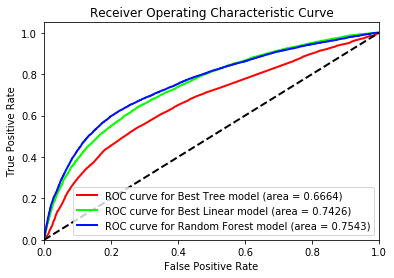

In [48]:
#AUC
rf_probs = rf_log2.predict_proba(features["test"])[:,1]
evaluation.roc_plot(test.funny,
                    [dt_best_preds, lin_probs, rf_probs],
                    ["Best Tree", "Best Linear", "Random Forest"],
                    'reports/figures/ROC_dt_best.svg')

One can see that the random forest model outperforms the benchmark linear model, however slightly.

In [49]:
#save best model
joblib.dump(rf_log2, "models/best_rf.pkl")

['models/best_rf.pkl']

##  Feature importance

In [27]:
#rf.score(features["test"], test.funny)

In [28]:
#rf.score(features["train"], train.funny)

In [29]:
#now auc
#rf_best_preds = rf.predict_proba(features["test"]) [:, 1]
#evaluation.roc_plot(test.funny, rf_best_preds, 'reports/figures/ROC_rf.svg')

In [51]:
top_rf_features = np.argsort(rf_log2.feature_importances_)[-50:]
np.array(features["vectorizer"].get_feature_names())[top_rf_features]

array(['best', 'night', 'old', 'women', 'replies', 'didn', 'friend', 'bar',
       'today', 'called', 'new', 'girl', 'jokes', 'want', 'trump',
       'girlfriend', 'going', 'think', 'woman', 'favorite', 've', 'really',
       'asks', 'tell', 'guy', 'sex', 'hear', 'good', 'told', 'black',
       'asked', 'make', 'day', 'll', 'time', 'difference', 'got', 'people',
       'wife', 'joke', 'said', 'know', 'don', 'man', 'says', 'say', 'does',
       'just', 'like', 'did'],
      dtype='<U59')